# Bernoulli Experiment P Values

In [2]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
MAX_GRAPH_SIZE = 1024

In [4]:
class Experiment(object):
    def __init__(self, stopping_rule):
        self.stopping_rule = stopping_rule
        self.graph = None
        self._path_count_cache = None
        
        self._make_graph()
        
        self.stopping_rule = set(self.stopping_rule)
        self.stopping_rule = list(filter(self.graph.has_node, self.stopping_rule))
        self.stopping_rule.sort(key=lambda n: n[0] / (n[0] + n[1]))
        
        self._compute_path_counts()
        
    def _make_graph(self):
        node_queue = [(0, 0)]
        self.graph = nx.DiGraph()
        self.graph.add_node((0, 0))

        while len(node_queue) > 0:
            n = node_queue.pop(0)
            if n in self.stopping_rule:
                continue
            elif max(n) == MAX_GRAPH_SIZE:
                self.stopping_rule.append(n)
                continue
            h_neighbor = (n[0] + 1, n[1])
            t_neighbor = (n[0], n[1] + 1)
            if not self.graph.has_node(h_neighbor):
                self.graph.add_node(h_neighbor)
                node_queue.append(h_neighbor)
            if not self.graph.has_node(t_neighbor):
                self.graph.add_node(t_neighbor)
                node_queue.append(t_neighbor)
            self.graph.add_edges_from([(n, h_neighbor), (n, t_neighbor)])
            
    def _compute_path_counts(self):
        node_queue = [(0, 0)]
        self._path_count_cache = {n: 0 for n in self.graph.nodes()}
        self._path_count_cache[(0, 0)] = 1
        
        while len(node_queue) > 0:
            n = node_queue.pop(0)
            for u in self.graph.neighbors(n):
                if self._path_count_cache[u] == 0:
                    node_queue.append(u)
                self._path_count_cache[u] += self._path_count_cache[n]
            
            
    def draw(self, nodelist=None, **kwargs):
        if nodelist is None:
            nodelist = list(self.graph.nodes())
        edgelist = [(u, v) for (u, v) in self.graph.edges()
                    if u in nodelist and v in nodelist]
        pos = {n: n for n in self.graph.nodes()}
        node_size = [300 if n in self.stopping_rule else 60 for n in nodelist]
        node_color = [(0, 0, 0.8) if n in self.stopping_rule else (0, 0, 0) for n in nodelist]
        node_shape = ["o" if n in self.stopping_rule else "." for n in nodelist]
                
        nx.draw(
            self.graph,
            nodelist=nodelist,
            edgelist=edgelist,
            pos=pos,
            node_size=node_size,
            node_color=node_color,
            #node_shape=node_shape,
            **kwargs
        )
        
    def path_count(self, h, t):
        return self._path_count_cache.get((h, t), 0)
            
    def single_path_like(self, h, t, theta):
        return theta**h * (1 - theta)**t
    
    def likelihood(self, h, t, theta):
        return self.path_count(h, t) * self.single_path_like(h, t, theta)
    
    def pdf(self, theta):
        return np.array([self.likelihood(h, t, theta)
                         for (h, t) in self.stopping_rule])
    
    def cdf(self, theta):
        ps = self.pdf(theta)
        return np.cumsum(ps)
    
    def p_values(self, theta_0):
        null_probs = self.pdf(theta_0)
        low_pvals = self.cdf(theta_0)
        high_pvals = 1 - low_pvals + null_probs
        pvals = np.minimum(low_pvals, high_pvals)
        return pvals
    
    def angles(self):
        return np.array([h / (h + t) for (h, t) in exp.stopping_rule])

# Early Stopping

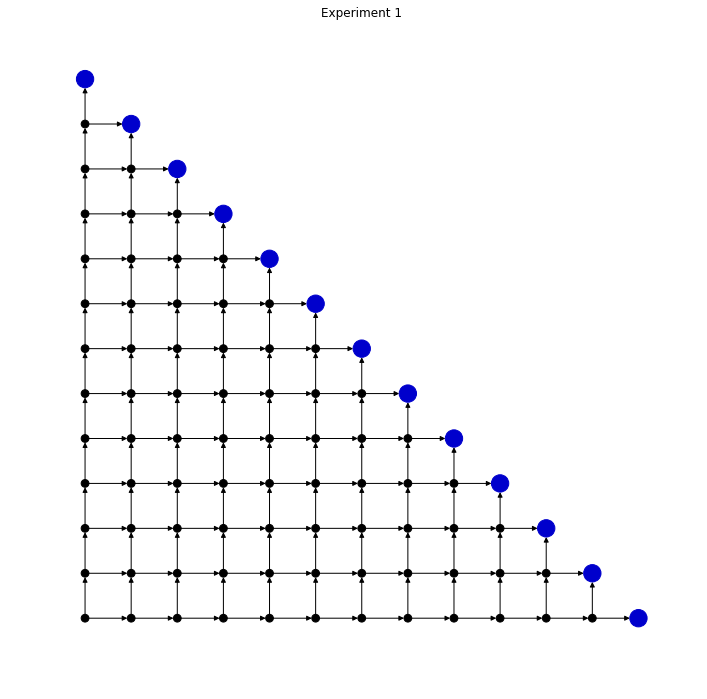

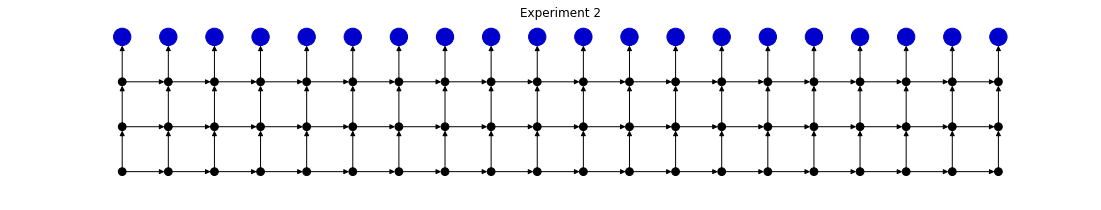

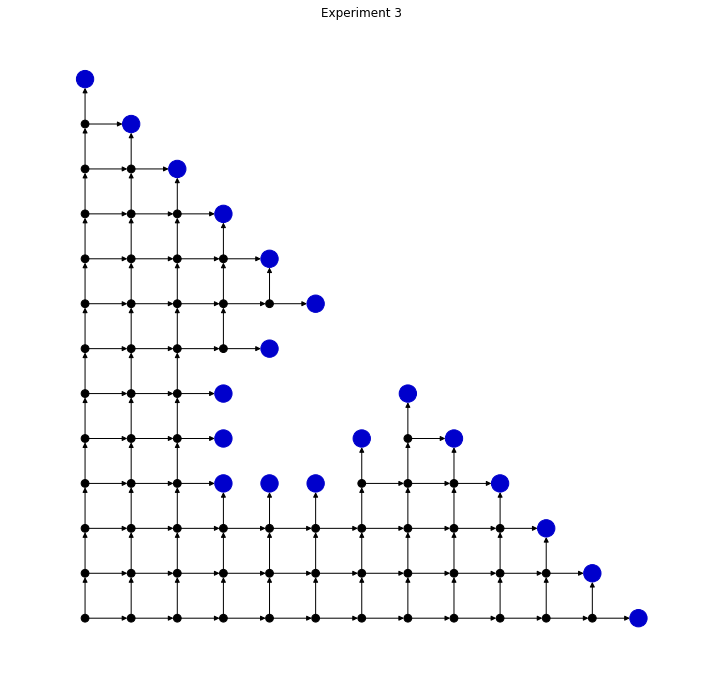

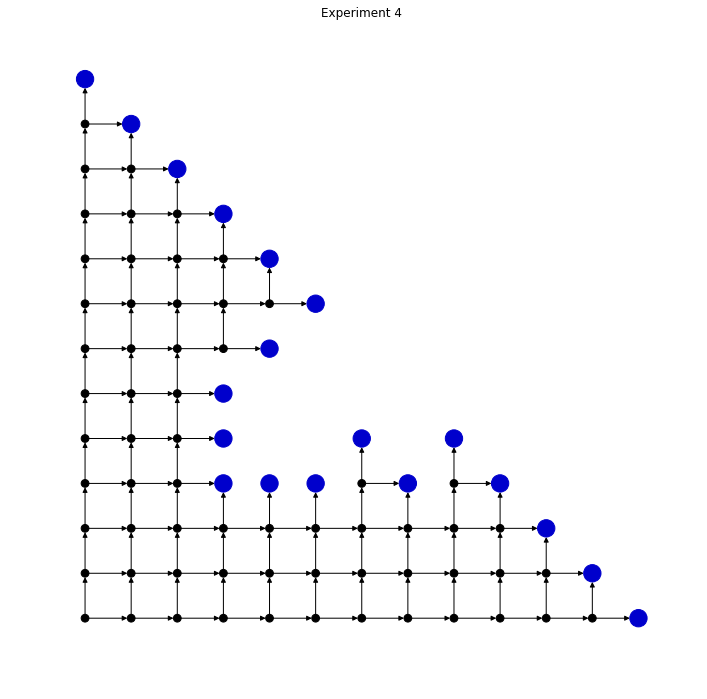

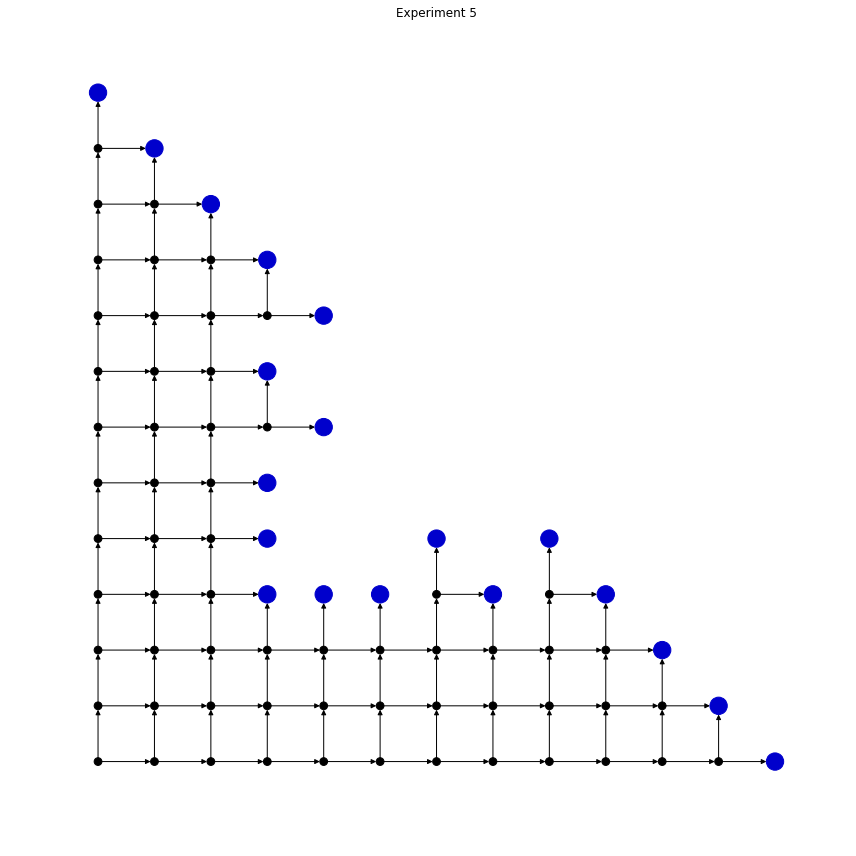

In [5]:
diag = 12
s1 = [(h, diag - h) for h in range(diag + 1)]
s2 = [(h, 3) for h in range(MAX_GRAPH_SIZE)]
s3 = s1 + [(3, 5), (3, 4), (3, 3), (4, 3), (5, 3), (6, 4), (4, 6)]
s4 = s3 + [(7, 3)]
s5 = s4 + [(3, 7)]

stopping_rules = [s1, s2, s3, s4, s5]

experiments = [Experiment(r) for r in stopping_rules]

for i, exp in enumerate(experiments):
    nodelist = [n for n in exp.graph.nodes() if max(n) < 20]
    width = max([h for (h, _) in nodelist])
    height = max([t for (_, t) in nodelist])

    plt.figure(figsize=(width, height))
    exp.draw(nodelist=nodelist, ax=plt.gca())
    plt.title(f"Experiment {i + 1}")
    
plt.tight_layout()
    
plt.show()

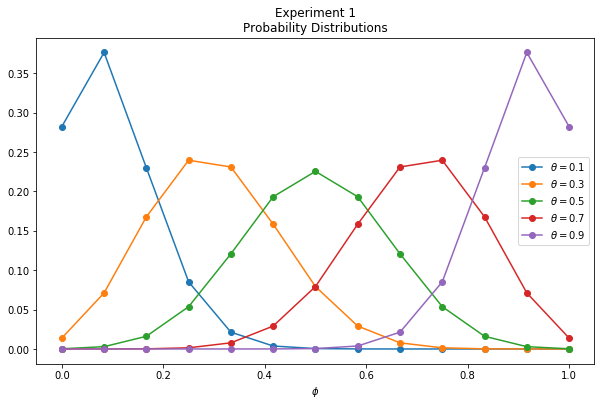

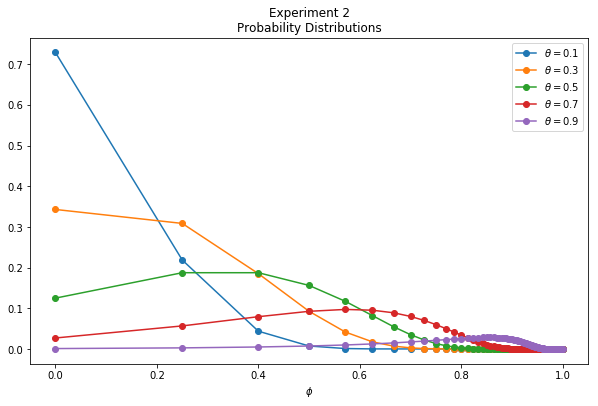

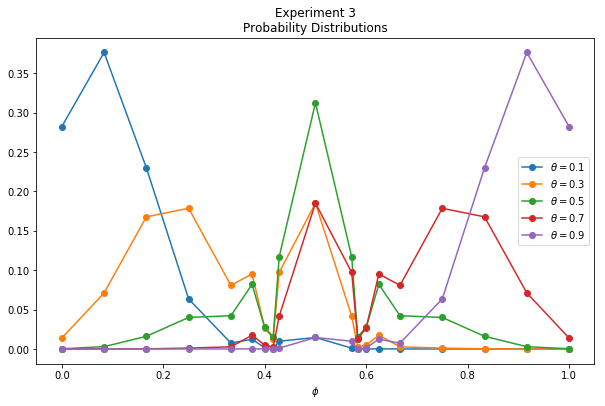

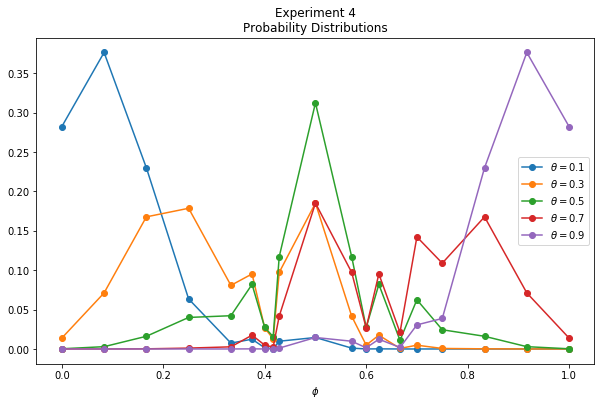

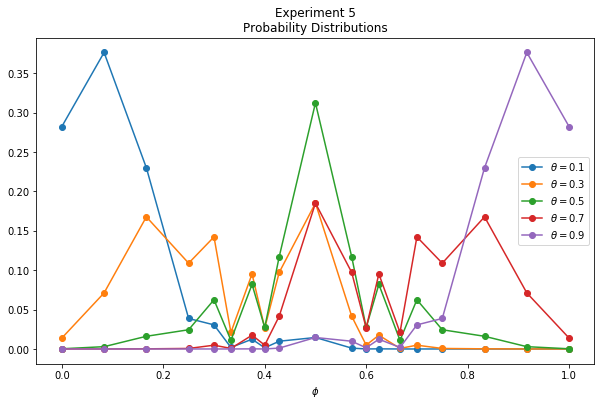

In [6]:
for i, exp in enumerate(experiments):
    plt.figure(figsize=(10, 6))

    angles = exp.angles()
        
    for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
        d = exp.pdf(t)
        plt.plot(angles, d, label=r"$\theta = $" + f"{t}", marker="o")
    
    plt.xlabel(r"$\phi$")
    plt.legend()
    plt.title(f"Experiment {i + 1}\nProbability Distributions")
    plt.show()

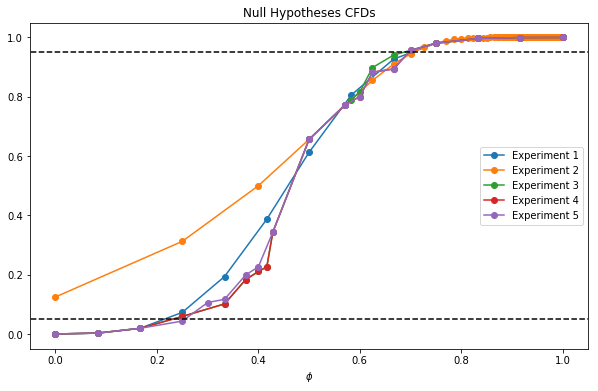

In [7]:
plt.figure(figsize=(10, 6))

for i in [1, 2, 3, 4, 5]:
    exp = experiments[i - 1]
    plt.plot(exp.angles(), exp.cdf(0.5), label=f"Experiment {i}", marker="o")

plt.plot([-1, 2], [0.05, 0.05], linestyle="dashed", color="black", scalex=False)
plt.plot([-1, 2], [0.95, 0.95], linestyle="dashed", color="black", scalex=False)

plt.xlabel(r"$\phi$")
plt.legend()
plt.title(f"Null Hypotheses CFDs")
plt.show()

In [9]:
def get_results(exp):
    thetas = np.linspace(0, 1, 21)
    pvals = exp.p_values(0.5)
    prob_dists = np.asfarray(exp.pdf(thetas))
    expected_pval = pvals @ prob_dists
    prob_significant = (pvals < 0.05) @ prob_dists
    return thetas, expected_pval, prob_significant

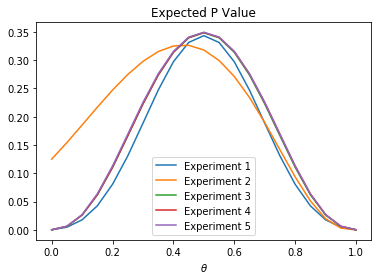

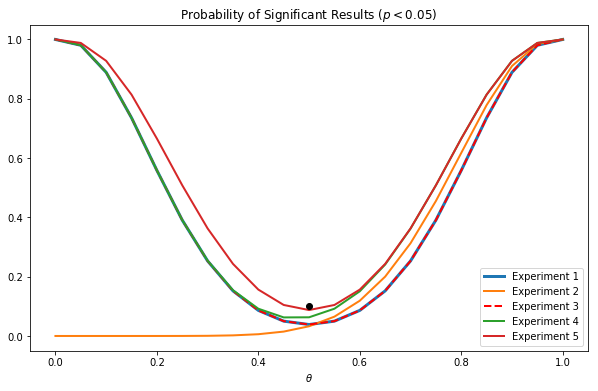

In [10]:
results = [get_results(exp) for exp in experiments]

plt.figure()
for i, (thetas, vs, _) in enumerate(results):
    plt.plot(thetas, vs, label=f"Experiment {i+1}")
plt.title("Expected P Value")
plt.xlabel(r"$\theta$")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, (thetas, _, vs) in enumerate(results):
    plt.plot(thetas, vs, label=f"Experiment {i+1}", 
             linewidth=3 if i == 0 else 2,
             linestyle="dashed" if i == 2 else None,
             color="red" if i == 2 else None)
plt.title(r"Probability of Significant Results ($p < 0.05$)")
plt.xlabel(r"$\theta$")
plt.plot([0.5], [0.1], marker="o", color="black")
plt.legend()
plt.show()

# p for Patience

In [31]:
def diag(n):
    return [(h, n - h) for h in range(n + 1)]

diag_experiments = {n: Experiment(diag(n)) for n in [16, 64, 256, 1024]}

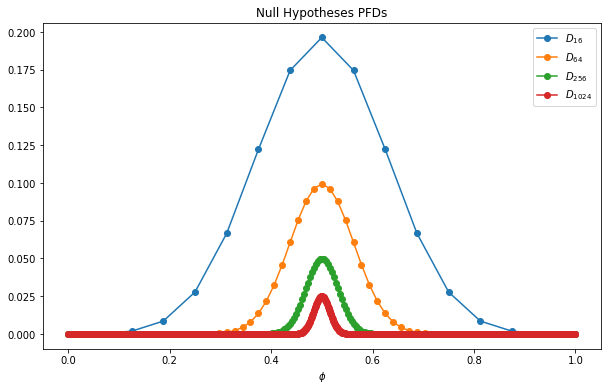

In [38]:
plt.figure(figsize=(10, 6))

for n, exp in diag_experiments.items():
    plt.plot(exp.angles(), exp.pdf(0.5), label=f"$D_{{ {n} }}$", marker="o")

plt.xlabel(r"$\phi$")
plt.legend()
plt.title(f"Null Hypotheses PFDs")
plt.show()

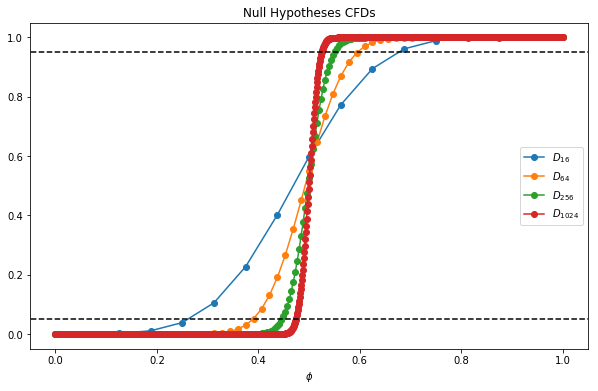

In [40]:
plt.figure(figsize=(10, 6))

for n, exp in diag_experiments.items():
    plt.plot(exp.angles(), exp.cdf(0.5), label=f"$D_{{ {n} }}$", marker="o")

plt.plot([-1, 2], [0.05, 0.05], linestyle="dashed", color="black", scalex=False)
plt.plot([-1, 2], [0.95, 0.95], linestyle="dashed", color="black", scalex=False)

plt.xlabel(r"$\phi$")
plt.legend()
plt.title(f"Null Hypotheses CFDs")

plt.savefig("paper_figs/diag_cdfs.png")
plt.show()

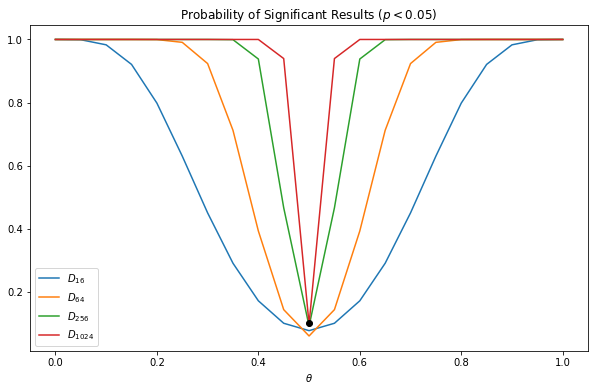

In [42]:
diag_results = {n: get_results(exp) for n, exp in diag_experiments.items()}

plt.figure(figsize=(10, 6))
for n, (thetas, _, vs) in diag_results.items():
    plt.plot(thetas, vs, label=f"$D_{{ {n} }}$")
    
plt.title(r"Probability of Significant Results ($p < 0.05$)")
plt.xlabel(r"$\theta$")
plt.plot([0.5], [0.1], marker="o", color="black")
plt.legend()
plt.savefig("paper_figs/diag_prob_significant.png")
plt.show()